Annie Taylor
8.24.22

### Analyzing Field Data

In [2]:
import pandas as pd
import numpy as np
import os
import csv
from IPython.display import display
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', 150)

import altair as alt
# import statsmodels.api as sm
import statsmodels.stats.multicomp
from scipy import stats
import scikit_posthocs as sp

import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [3]:
file = 'D:/1_AMLT/7_CascadeBiodiversity/Plot_Data_Cover_0824.csv'
data = pd.read_csv(file)
# display(data)

### Add data columns and select plant or group for analysis
11 plants in total have percent cover
- 6 are cultural plants
- 4 are invasive
- 7 are native

In [4]:
testcol = 'BAPI'

# make fire dfs
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']

# types of plants
cultural = ['ACMI', 'CHPO', 'DACA', 'FRCA', 'MASA', 'RUUR']
native = ['ACMI', 'BAPI', 'CHPO', 'DACA', 'FRCA', 'MASA', 'RUUR']
invasive = ['PHAQ', 'PLLA', 'HOLA', 'BRMA']

# lifeforms
shrubs = ['BAPI', 'FRCA', 'RUUR']
herbaceous = ['ACMI', 'CHPO', 'DACA', 'MASA', 'PHAQ', 'PLLA', 'HOLA', 'BRMA']

# add columns with these totals by plot to the dataframe
data['Cultural'] =  data[cultural].sum(axis=1)
data['Native'] =  data[native].sum(axis=1)
data['Invasive'] =  data[invasive].sum(axis=1)
data['Shrubs'] =  data[shrubs].sum(axis=1)
data['Herbaceous'] =  data[herbaceous].sum(axis=1)
# display(data)

### Add count columns for species richness analysis

In [5]:
# Add presence/absence column for all plants
plant_cols = ['ACMI','BAPI', 'CHPO', 'DACA', 'FRCA', 'MASA', 'PHAQ', 'PLLA', 'RUUR', 'HOLA', 'BRMA']
for plant in plant_cols: 
    new_name = 'P_' + plant
    data[new_name] = np.where(data[plant] > 0, 1, 0)

# Sum them up to calculate total cultural plant count, total invasive plant count
# types of plants
c_cultural = ['P_ACMI', 'P_CHPO', 'P_DACA', 'P_FRCA', 'P_MASA', 'P_RUUR']
c_native = ['P_ACMI', 'P_BAPI', 'P_CHPO', 'P_DACA', 'P_FRCA', 'P_MASA', 'P_RUUR']
c_invasive = ['P_PHAQ', 'P_PLLA', 'P_HOLA', 'P_BRMA']

# lifeforms
c_shrubs = ['P_BAPI', 'P_FRCA', 'P_RUUR']
c_herbaceous = ['P_ACMI', 'P_CHPO', 'P_DACA', 'P_MASA', 'P_PHAQ', 'P_PLLA', 'P_HOLA', 'P_BRMA']

# add columns with these totals by plot to the dataframe
data['CountCultural'] =  data[c_cultural].sum(axis=1)
data['CountNative'] =  data[c_native].sum(axis=1)
data['CountInvasive'] =  data[c_invasive].sum(axis=1)
data['CountShrubs'] =  data[c_shrubs].sum(axis=1)
data['CountHerbaceous'] =  data[c_herbaceous].sum(axis=1)
data['TotalSpeciesCount'] = data['CountShrubs'] + data['CountHerbaceous']
# display(data.head(5))

### Add Native Invasive Counts from SpeciesList

In [6]:
# lists of native and invasive for categorization of species richness
cultural_spp = [
    'Achillea millefolium',
    'Chlorogalum pomeridianum',
    'Danthonia californica',
    'Frangula californica',
    'Madia sativa',
    'Rubus ursinus',
    'Scrophularia californica' # this is a rogue addition based on convos with Rob
]

native_spp = ['Achillea millefolium',
              'Baccharis pilularis',
              'Chlorogalum pomeridianum',
              'Danthonia californica',
              'Eschscholzia californica',
              'Frangula californica',
              'Galium aparine',
              'Juncus patens',
              'Lupinus nanus',
              'Madia sativa',
              'Pentagramma triangularis',
              'Ranunculus californicus',
              'Rubus ursinus',
              'Sanicula crassicaulis',
              'Scrophularia californica',
              'Sidalcea malviflora',
              'Sisyrinchium bellum',
              'Symphyotrichum chilense',
              'Taraxia ovata',
              'Triphysaria versicolor ssp. versicolor'
             ]

invasive_spp = ['Aira caryophyllea',
                'Avena barbata',
                'Bellardia viscosa',
                'Briza maxima',
                'Briza minor',
                'Bromus diandrus',
                'Bromus hordeaceus',
                'Carduus pycnocephalus',
                'Conium maculatum',
                'Festuca arundinacea',
                'Festuca bromoides',
                'Festuca myuros',
                'Geranium dissectum',
                'Helminthotheca echioides',
                'Holcus lanatus',
                'Lotus corniculatus',
                'Lysimachia arvensis',
                'Phalaris aquatica',
                'Plantago lanceolata',
                'Rumex acetosella',
                'Senecio glomeratus',
                'Trifolium dubium',
                'Vicia benghalensis',
                'Vicia sativa',
                'Vicia tetrasperma'
               ]

likely_invasive = [
    'Subfamily Cichorioideae',
    'Daucus'
]

likely_native = [
    'Cardamine',
    'Juncus',
    'Family Polygonaceae'
]

unknown = [
    'Trifolium',
    'Cirsium'
]

# Also categorize by lifeforms

native_herbaceous_spp = [
    'Achillea millefolium',
      'Chlorogalum pomeridianum',
      'Danthonia californica',
      'Eschscholzia californica',
      'Galium aparine',
      'Juncus patens',
      'Lupinus nanus',
      'Madia sativa',
      'Pentagramma triangularis',
      'Ranunculus californicus',
      'Sanicula crassicaulis',
      'Scrophularia californica',
      'Sidalcea malviflora',
      'Sisyrinchium bellum',
      'Symphyotrichum chilense',
      'Taraxia ovata',
      'Triphysaria versicolor ssp. versicolor'
]

shrub_spp = [
    'Baccharis pilularis',
    'Frangula californica',
    'Rubus ursinus'
]

# expand each species into its own column in a diff data fram
# use list comprehension to count total native species richness etc. 
sppcalc = data['SpeciesList'].str.split(pat=', ', expand=True)
# sppcalc['SpeciesListCount'] = data['SpeciesListCount']
# sppcalc['SpeciesList'] = data['SpeciesList'] #can add this for ground truthing the split
sppcalc['SL_Cultural'] = sppcalc.apply(lambda a: sum([1 for a in a if a in cultural_spp]), axis=1)
sppcalc['SL_Native'] = sppcalc.apply(lambda a: sum([1 for a in a if a in native_spp or a in likely_native]), axis=1)
sppcalc['SL_Invasive'] = sppcalc.apply(lambda a: sum([1 for a in a if a in invasive_spp or a in likely_invasive]), axis=1)
sppcalc['SL_NatHerb'] = sppcalc.apply(lambda a: sum([1 for a in a if a in native_herbaceous_spp]), axis=1)
sppcalc['SL_NatShrub'] = sppcalc.apply(lambda a: sum([1 for a in a if a in shrub_spp]), axis=1)
# display(sppcalc)

# can select true / false for one species # display(data['SpeciesList'].str.contains('Lotus corniculatus'))
# or true / false for one of a list of species # display(data2['SpeciesList'].str.contains('|'.join(native_spp)))

# Link back sppcalc results back up with my dataframe
sppcalc = sppcalc[['SL_Cultural', 'SL_Native', 'SL_Invasive', 'SL_NatHerb', 'SL_NatShrub']]
data = data.join(sppcalc)
# display(data)

#### Get site-level species richness into these four groups as well

In [8]:
# split data into the three sites
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']

# create empty dataframe to fill in with site level species richness values
SRresult = pd.DataFrame(index=['RX', 'CZU', 'NO'])

columnnames = ['native_herbaceous_SR', 'shrub_SR', 'invasive_SR', 'cultural_SR',
               'native_SR', 'likely_native_SR', 'likely_invasive_SR']
lists = [native_herbaceous_spp, shrub_spp, invasive_spp, cultural_spp, native_spp, likely_native, likely_invasive]


for plantlist, colname in zip(lists, columnnames):
    SRresult.at['RX', colname] = sum([1 for plant in plantlist if rxfire['SpeciesList'].str.contains(plant).any()])
    SRresult.at['CZU', colname] = sum([1 for plant in plantlist if wildfire['SpeciesList'].str.contains(plant).any()])
    SRresult.at['NO', colname] = sum([1 for plant in plantlist if nofire['SpeciesList'].str.contains(plant).any()])
# print(SRresult)

# export to csv
# SRresult.to_csv('D:/1_AMLT/7_CascadeBiodiversity/SiteLevel_SpeciesRichnessbyGroup_033023.csv')

### Boxplots to compare percent cover across the three sites

In [18]:
# ACMI BAPI CHPO DACA FRCA MASA PHAQ PLLA RUUR HOLA BRMA
testcol = 'BAPI'

alt.Chart(data).mark_boxplot().encode(
    x = alt.X('Site',
            axis=alt.Axis(title="Fire Type")),
    y = alt.Y(testcol, scale=alt.Scale(domain=[0, 100]))
).properties(width=400).configure_legend(labelFontSize=14,
                   titleFontSize=14,
                   symbolSize = 250,
                   padding=10
).configure_axis(labelFontSize=14,titleFontSize=14)

alt.Chart(...)

### ANOVA test - univariate, for the selected plant or column

In [16]:
# fire sites split
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']

# run anova
F, p = stats.f_oneway(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'ANOVA test for {testcol}')
print(f'F-Statistic={F:.3f}, p={p:.3f}')

ANOVA test for BAPI
F-Statistic=20.464, p=0.000


### Post Hoc Test: HSD Tukey (pairwise testing)
Test which sites differ significantly for that plant cover

In [19]:
mc = statsmodels.stats.multicomp.MultiComparison(data[testcol], data['Site'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper   reject
-----------------------------------------------------
   CZU     NO   17.561    0.0  9.7118  25.4102   True
   CZU     RX  -1.3647 0.9095  -9.167   6.4376  False
    NO     RX -18.9257    0.0 -26.728 -11.1233   True
-----------------------------------------------------


### Multivariate ANOVA
Compare the distributions of all of the plants' percent cover across fire groups

In [16]:
# from statsmodels.multivariate.manova import MANOVA

# maov = MANOVA.from_formula('ACMI+BAPI+CHPO+DACA+FRCA+MASA+PHAQ+PLLA+RUUR+HOLA+BRMA ~ Site', data=data)
# maov_inv = MANOVA.from_formula('Cultural+Invasive ~ Site', data=data)
# maov_form = MANOVA.from_formula('Shrubs+Herbaceous ~ Site', data=data)

# # print(maov.mv_test())
# print(maov_inv.mv_test())
# # print(maov_form.mv_test())

## Test ANOVA and MANOVA assumptions

#### Testing for correlation between the dependent variables (plant cover)
Using a scatterplot matrix to check all of the relationships, no correlation

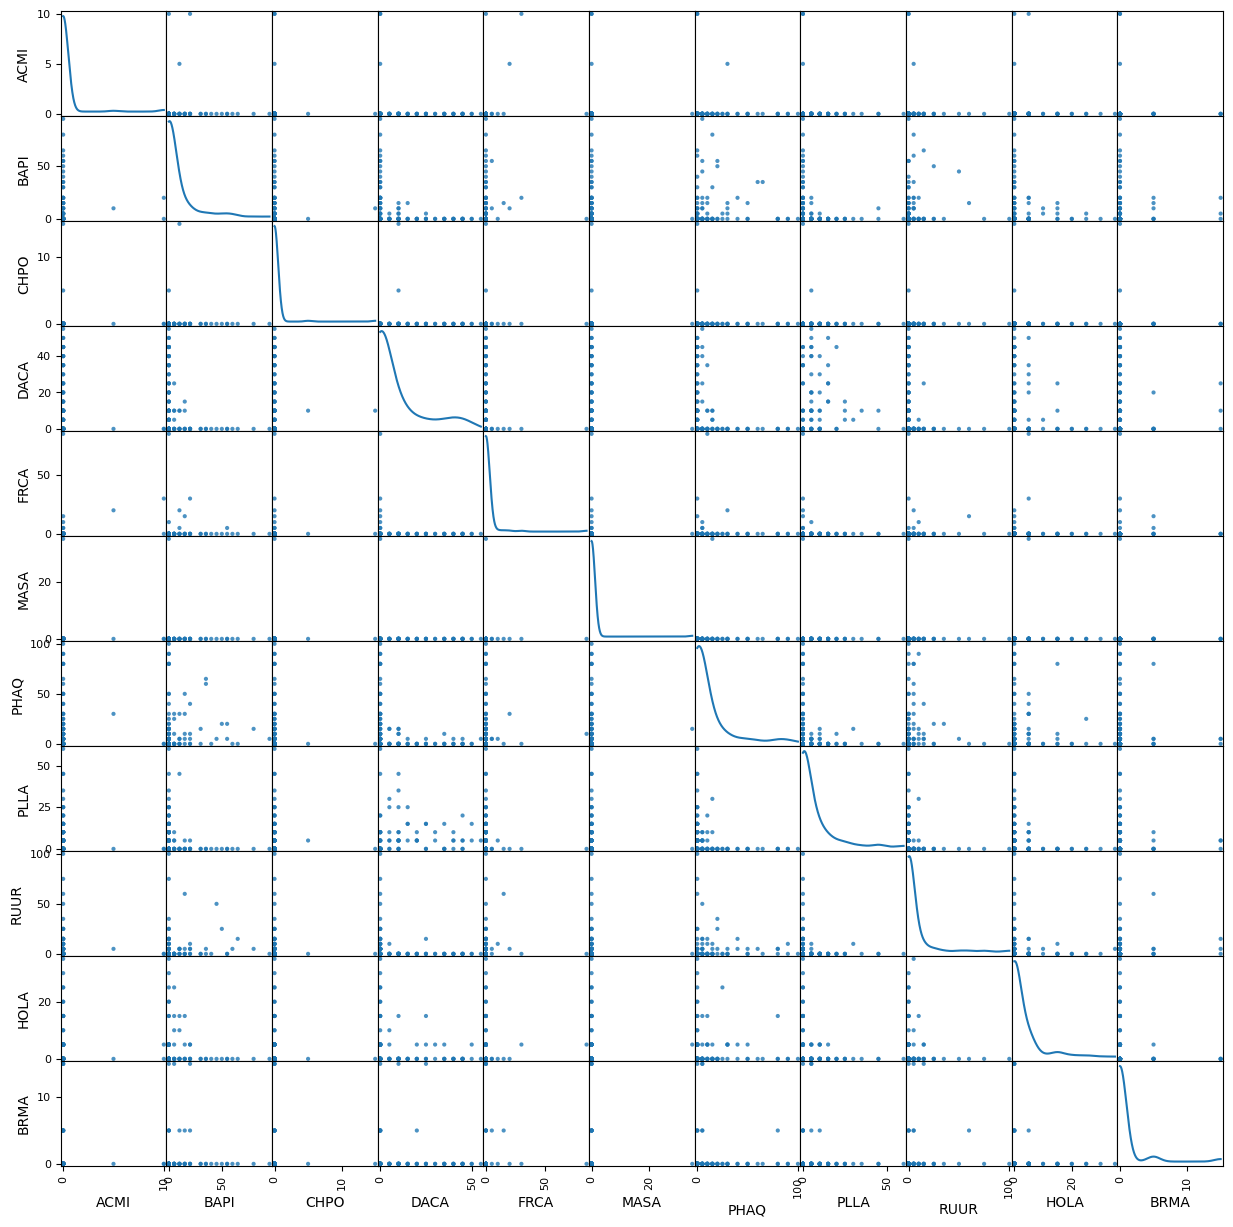

In [21]:
plants = data[data.columns[4:15]]
# display(plants)
pd.plotting.scatter_matrix(plants, alpha = 0.8, figsize=(15,15), diagonal = 'kde')

# same for categories, nothing is correlated
# plantforms = data[['Shrubs', 'Herbaceous']]
# plantstatus = data[['Cultural', 'Invasive']]
# display(plantstatus)
# pd.plotting.scatter_matrix(plantstatus, alpha = 0.8, figsize=(5,5), diagonal = 'kde')

#### Test for correlations
Calculates pearson correlation coefficient 0 to 1 for each column pair

None were correlated

In [23]:
# Create correlation matrix
corr_matrix = plants.corr()
display(corr_matrix)
# optionally can check if any correlation values are greater than a threshold
# no correlations
filt = (corr_matrix.abs() >= 0.50)
display(corr_matrix[filt])

corr_matrix = plantforms.corr()
display(corr_matrix)

corr_matrix = plantstatus.corr()
display(corr_matrix)

,ACMI,BAPI,CHPO,DACA,FRCA,MASA,PHAQ,PLLA,RUUR,HOLA,BRMA
ACMI,1.000000,0.020685,-0.017307,-0.094460,0.264881,-0.013649,-0.036600,-0.081482,-0.040897,-0.019586,-0.036514
BAPI,0.020685,1.000000,-0.001077,-0.253062,0.002682,-0.040362,0.037195,-0.206666,0.079770,-0.122768,0.004774
CHPO,-0.017307,-0.001077,1.000000,0.005919,-0.018749,-0.010309,-0.059481,-0.047198,-0.039108,-0.050759,-0.027579
DACA,-0.094460,-0.253062,0.005919,1.000000,-0.102329,-0.056265,-0.276584,0.124962,-0.196797,-0.157029,-0.014680
FRCA,0.264881,0.002682,-0.018749,-0.102329,1.000000,-0.014786,-0.015922,-0.083429,0.021923,0.014438,-0.001086
MASA,-0.013649,-0.040362,-0.010309,-0.056265,-0.014786,1.000000,0.015861,-0.048535,-0.030842,0.030881,-0.021750
PHAQ,-0.036600,0.037195,-0.059481,-0.276584,-0.015922,0.015861,1.000000,-0.235897,-0.029967,-0.042586,-0.035932
PLLA,-0.081482,-0.206666,-0.047198,0.124962,-0.083429,-0.048535,-0.235897,1.000000,-0.162301,-0.200780,-0.057208
RUUR,-0.040897,0.079770,-0.039108,-0.196797,0.021923,-0.030842,-0.029967,-0.162301,1.000000,-0.101707,0.067779
HOLA,-0.019586,-0.122768,-0.050759,-0.157029,0.014438,0.030881,-0.042586,-0.200780,-0.101707,1.000000,-0.094444


,ACMI,BAPI,CHPO,DACA,FRCA,MASA,PHAQ,PLLA,RUUR,HOLA,BRMA
ACMI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BAPI,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHPO,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DACA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FRCA,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
MASA,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
PHAQ,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PLLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
RUUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
HOLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


,SL_NatHerb,SL_NatShrub
SL_NatHerb,1.000000,-0.177767
SL_NatShrub,-0.177767,1.000000


,SL_Native,SL_Invasive
SL_Native,1.000000,-0.083947
SL_Invasive,-0.083947,1.000000


#### Test for normal distributions

They are not normal (right skewed)

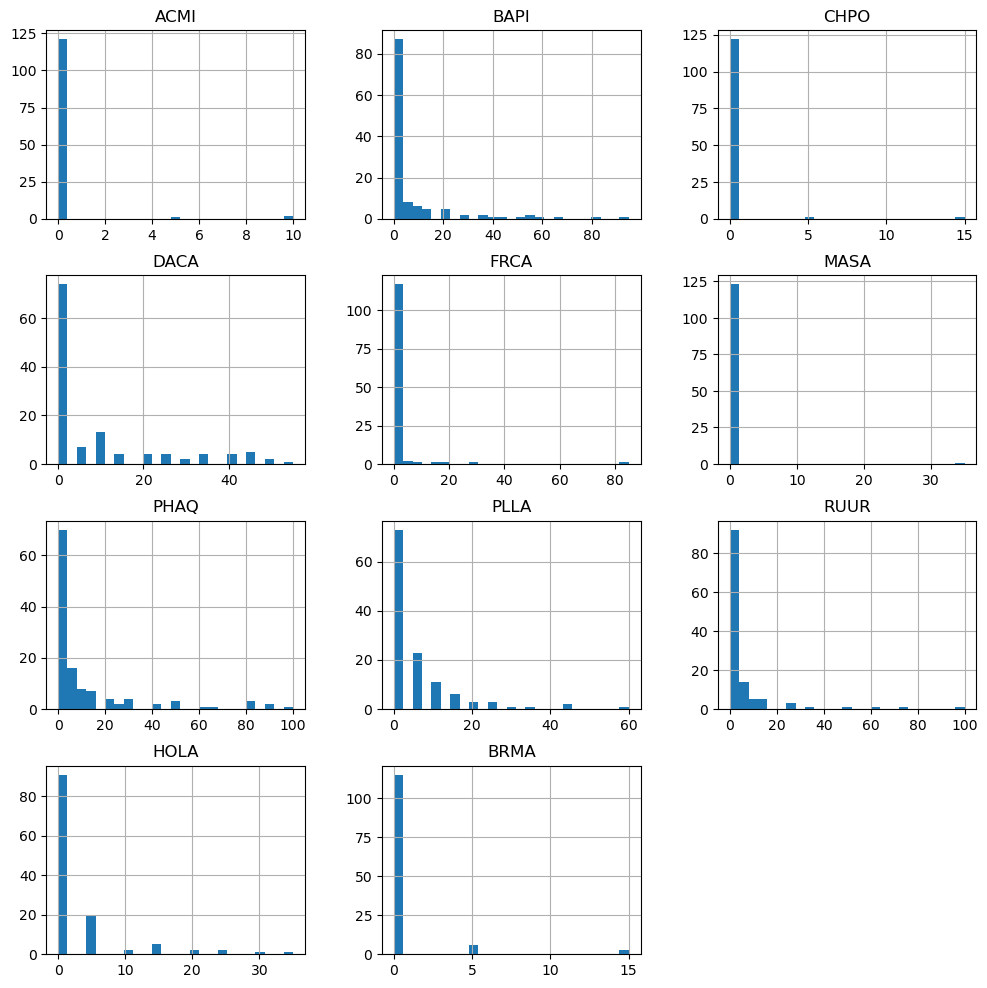

In [19]:
histos = plants.hist(figsize=(12,12), bins=25)

### Kruskal-Wallis Test = non-parametric ANOVA
- Doesn't assume the distributions of the dependent variables are normal (in my case they are right skewed)
- Generally less powerful than ANOVA but should use it when assumptions aren't met
- Test shows if at least one site is different from the other two, use Dunn test for pairwise comparisons


In [26]:
F, p = stats.kruskal(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'Kruskal-Wallis test for {testcol}:\nF-Statistic={F:.4f}, p={p:.4f}')

Kruskal-Wallis test for BAPI:
F-Statistic=33.3311, p=0.0000


### Dunn test = post hoc pairwise comparisons
Adjusted p-values = adjusted for multiple comparisons

In [29]:
p_values = sp.posthoc_dunn(data, val_col=testcol, group_col='Site', sort=False)
# display(p_values)

# czu versus no, then czu vs rx, then no vs rx
p1 = p_values.loc['CZU', 'NO']
p2 = p_values.loc['CZU', 'RX']
p3 = p_values.loc['NO', 'RX']

reject = []
for p in [p1, p2, p3]:
    if p >= 0.05:
        reject.append("False - no sig diff")
    else:
        reject.append('True - sig diff')

print(f'Posthoc Dunn test for {testcol}')
print(f'CZU versus NO fire, {reject[0]}, p_Holm = {p1:0.4f}')
print(f'CZU versus RX fire, {reject[1]}, p_Holm = {p2:0.4f}')
print(f'RX  versus NO fire, {reject[2]}, p_Holm = {p3:0.4f}')

Posthoc Dunn test for BAPI
CZU versus NO fire, True - sig diff, p_Holm = 0.0001
CZU versus RX fire, False - no sig diff, p_Holm = 0.0828
RX  versus NO fire, True - sig diff, p_Holm = 0.0000


#### Prep data for a cool violin plot with stats measures on it
from: https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/src/notebooks/web-ggbetweenstats-with-matplotlib.ipynb

In [30]:
# Get the species, sorted alphabetically
sites = sorted(data["Site"].unique())

# y_data is a list of length 3 containing the percent cover values for each fire group 
y_data = [data[data["Site"] == firegroup][testcol].values for firegroup in sites]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
# Without jitter, the representation of the percent cover for a given fire group would be placed on a vertical line
# Jittering is added to reduce overlap and make it easier to perceive the shape of the distribution
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

Text(0.122, 0.975, 'Distribution of percent cover of BAPI across fire groups')

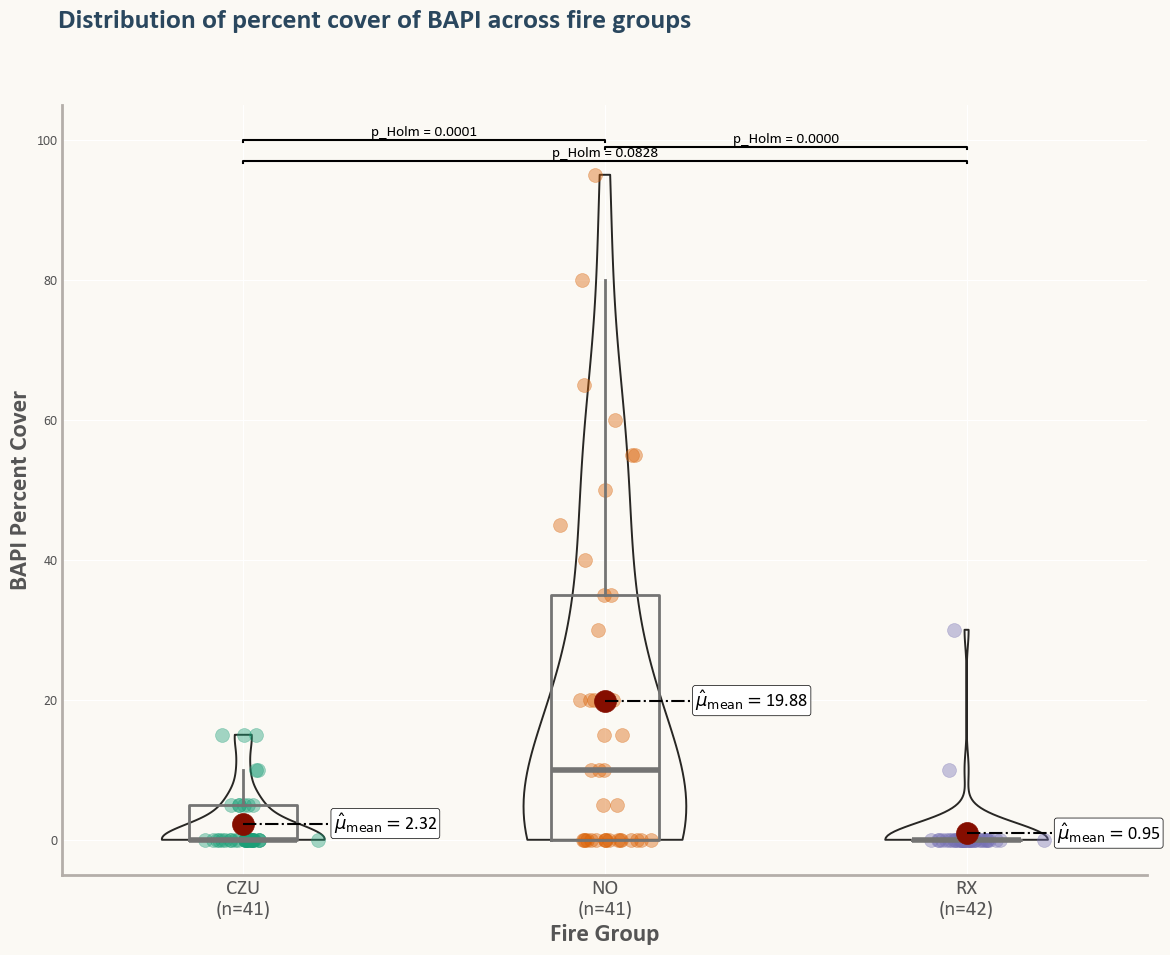

In [31]:
plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
plt.rcParams['font.family'] = 'Calibri'

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [0, 1, 2]

fig, ax = plt.subplots(figsize= (14, 10))

# Some layout stuff ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 100, color=color, alpha=0.4)
    

# Add mean value labels ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add dot representing the mean
    ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
    
    # Add line conecting mean value and its label
    ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
    
    # Add mean value label.
    ax.text(
        i + 0.25,
        mean,
        r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 2)),
        fontsize=13,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )

# Add multiple comparisons p-value for mean difference -----------
# Plot lines indicating what means are compared
# 'tick_len' gives the length of the tick on the end of each line

tick_len = 0.25
# set heights of p value bars based on max in test column
num = data[testcol].max()
num1, num2, num3 = num + 5, num + 2, num + 4
ax.plot([0, 0, 1, 1], [num1 - tick_len, num1, num1, num1 - tick_len], c="black")
ax.plot([0, 0, 2, 2], [num2 - tick_len, num2, num2, num2 - tick_len], c="black")
ax.plot([1, 1, 2, 2], [num3 - tick_len, num3, num3, num3 - tick_len], c="black")


# Add labels for the p-values
# these are defined above as p1, p2, p3
label1 = f'p_Holm = {p1:0.4f}'
label2 = f'p_Holm = {p2:0.4f}'
label3 = f'p_Holm = {p3:0.4f}'

pad = 0.2
ax.text(0.5, num1 + pad, label1, fontsize=11, va="bottom", ha="center")
ax.text(1, num2 + pad, label2, fontsize=11, va="bottom", ha="center")
ax.text(1.5, num3 + pad, label3, fontsize=11, va="bottom", ha="center")      
    
    
# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_ylabel(testcol + " Percent Cover", size=18, weight="bold")

# xlabels accounts for the sample size for each fire group
xlabels = [f"{site}\n(n={y_data[i].size})" for i, site in enumerate(sites)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("Fire Group", size=18, weight="bold")

fig.suptitle(
    "Distribution of percent cover of " + testcol + " across fire groups",
    x = 0.122,
    y = 0.975,
    ha="left",
    fontsize=20,
    color=BLUE,
    weight="bold",    
)